<a href="https://colab.research.google.com/github/jangedoo/image-similarity-demo/blob/master/notebooks/Image_Search_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import functools

In [7]:
(train_ds, valid_ds), info = tfds.load("oxford_flowers102", split=["train", "validation"], as_supervised=True, with_info=True)
int_to_class_label = info.features['label'].int2str

In [8]:
CLASSES_TO_CONSIDER = list(range(20)) # first 20 classes
IMG_WIDTH = IMG_HEIGHT = 256

def preprocess_image(image, label, height, width):
    image = tf.image.resize_with_crop_or_pad(image, target_height=height, target_width=width)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def filter_by_classes(img, label):
    bools = tf.equal(label, CLASSES_TO_CONSIDER)
    return tf.reduce_any(bools)    


partial_preprocess_image = functools.partial(preprocess_image, height=IMG_HEIGHT, width=IMG_WIDTH)
train_ds = train_ds.filter(filter_by_classes).map(partial_preprocess_image).cache().shuffle(buffer_size=1000)
valid_ds = valid_ds.filter(filter_by_classes).map(partial_preprocess_image).cache().shuffle(buffer_size=1000)

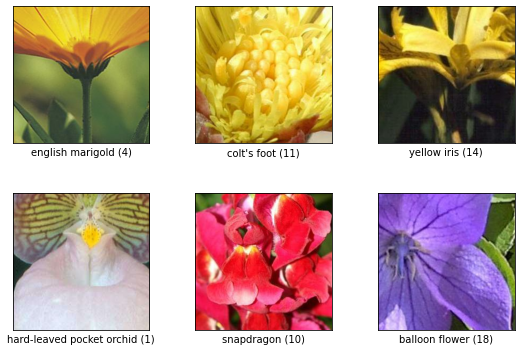

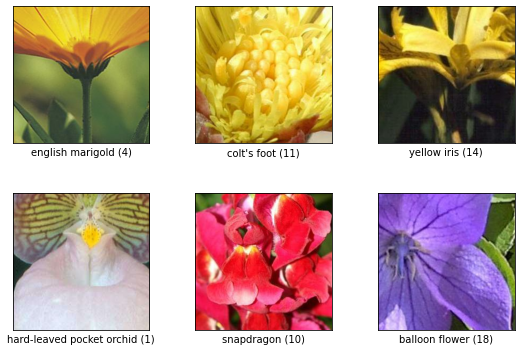

In [9]:
tfds.show_examples(train_ds, ds_info=info, rows=2, cols=3)

In [10]:

def get_x_y_from_ds(ds):
    x, y = [], []
    for img, label in ds.cache().as_numpy_iterator():
        x.append(img)
        y.append(label)

    return np.array(x), np.array(y)

x_train, y_train = get_x_y_from_ds(train_ds)
x_test, y_test = get_x_y_from_ds(valid_ds)
print(len(x_train), len(y_train), len(x_test), len(y_test))

200 200 200 200


# Extract vectors and plot the embeddings

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

def plot_embeddings(features, labels):    
    pca = TSNE(n_components=2, learning_rate='auto', init='pca')
    reduced_features = pca.fit_transform(features)
    str_labels = list(map(int_to_class_label, labels))
    fig = px.scatter(x=reduced_features[:,0], y=reduced_features[:,1], color=str_labels, symbol=labels)
    fig.show()

In [12]:
MODEL_URL = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [13]:
vectorizer = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL, trainable=False)
])
vectorizer.build([None, IMG_HEIGHT, IMG_WIDTH, 3])
vectorizer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
Total params: 23,564,800
Trainable params: 0
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
pre_trained_features = vectorizer.predict(x_test)
plot_embeddings(features=pre_trained_features, labels=y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [15]:
from sklearn.neighbors import NearestNeighbors
def get_knn(features):
    knn = NearestNeighbors(n_neighbors=5, metric="cosine")
    knn.fit(features)
    return knn

import ipywidgets as w
def show_similar_images(images, labels, vectorizer, knn, start_image_idx, n_inputs=5, n_neighbors=10):
    input_images = images[start_image_idx:start_image_idx+n_inputs]
    features = vectorizer.predict(input_images)
    knn_output = knn.kneighbors(features, n_neighbors=n_neighbors)
    
    images_with_distances_and_nbors = zip(input_images, *knn_output)
    
    fig, axes = plt.subplots(len(input_images), n_neighbors+1, figsize=(20, len(input_images)*4))
    
    for i, (image, distances, nbors) in enumerate(images_with_distances_and_nbors):
        for j in range(n_neighbors+1):
            ax = axes[i, j]
            img = (image if j==0 else images[nbors[j-1]])
            if j == 0:
                ax.set_title("Input Image")
            else:
                ax.set_title(f"Sim: {1-distances[j-1]:.2f}")
                ax.set_xlabel(f"lbl: {labels[nbors[j-1]]}")
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            ax.imshow(img)

In [16]:
pretrained_knn = get_knn(features=pre_trained_features)
w.interact(show_similar_images, images=w.fixed(x_test), labels=w.fixed(y_test), vectorizer=w.fixed(vectorizer), knn=w.fixed(pretrained_knn),
    start_image_idx=w.IntSlider(max=len(x_test)-1, continuous_update=False),
    n_inputs=w.IntSlider(min=2, value=5, max=10, continuous_update=False),
    n_neighbors=w.IntSlider(min=2, value=5, max=10, continuous_update=False),
) # 74 has weird results

interactive(children=(IntSlider(value=0, continuous_update=False, description='start_image_idx', max=199), Int…

<function __main__.show_similar_images>

# Fine tune the model

In [58]:
tuned_vectorizer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    hub.KerasLayer(MODEL_URL, trainable=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(384, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])
tuned_vectorizer.build([None, IMG_HEIGHT, IMG_WIDTH, 3])
tuned_vectorizer.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_6 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_6 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 keras_layer_7 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 384)               786816    
                                                                 
 lambda_6 (Lambda)           (None, 384)               0         
                                                      

On all datasets we train using a batch size of 128. Batches are
constructed with a fixed number n examples per class by adding
classes until the batch is full. When a class has fewer than n
examples, we use all the examples from the class. If this leads
to a case where the last class in the batch does not have space
for n images, we just include enough images to fill the batch

In [20]:
from collections import defaultdict
import random

def get_training_batch(images, labels, batch_size=128, n_examples_per_class=3):
    examples_per_class = defaultdict(list)
    for x, y in zip(images, labels):
        examples_per_class[y].append(x)
    
    while True:
        batch_X, batch_y = [], []
        while len(batch_X) < batch_size:
            for cls, examples in examples_per_class.items():
                n_sample = min(n_examples_per_class, (batch_size - len(batch_X)))
                if n_sample == 0:
                    break
                samples = random.sample(examples, k=n_sample)
                batch_X.extend(samples)
                batch_y.extend([cls] * len(samples))

        yield np.array(batch_X), np.array(batch_y)


In [ ]:
! pip install tensorflow_addons

In [59]:
bs = 64
n_examples_per_class = 3
initial_lr = 0.0001
epochs = 80
import tensorflow_addons as tfa

tuned_vectorizer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                         loss=tfa.losses.TripletSemiHardLoss())

history = tuned_vectorizer.fit(get_training_batch(images=x_train, labels=y_train, batch_size=bs, n_examples_per_class=n_examples_per_class),
                               callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
                               epochs=epochs, 
                               steps_per_epoch=len(x_train)//bs, 
                               validation_data=(x_test, y_test),
                               validation_batch_size=bs,
                              )

Epoch 1/80
3/3 [==============================] - 13s 1s/step - loss: 1.2295 - val_loss: 1.1830
Epoch 2/80
3/3 [==============================] - 3s 1s/step - loss: 1.2226 - val_loss: 1.1624
Epoch 3/80
3/3 [==============================] - 3s 1s/step - loss: 1.1953 - val_loss: 1.1398
Epoch 4/80
3/3 [==============================] - 3s 1s/step - loss: 1.1615 - val_loss: 1.1127
Epoch 5/80
3/3 [==============================] - 3s 1s/step - loss: 1.0942 - val_loss: 1.0847
Epoch 6/80
3/3 [==============================] - 3s 1s/step - loss: 1.0781 - val_loss: 1.0489
Epoch 7/80
3/3 [==============================] - 3s 1s/step - loss: 1.0200 - val_loss: 1.0158
Epoch 8/80
3/3 [==============================] - 3s 1s/step - loss: 0.9618 - val_loss: 0.9920
Epoch 9/80
3/3 [==============================] - 3s 1s/step - loss: 0.9309 - val_loss: 0.9773
Epoch 10/80
3/3 [==============================] - 3s 1s/step - loss: 0.8888 - val_loss: 0.9598
Epoch 11/80
3/3 [==============================]

In [60]:
frozen_features = tuned_vectorizer.predict(x_test)
plot_embeddings(features=frozen_features, labels=y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [61]:
frozen_knn = get_knn(features=frozen_features)
w.interact(show_similar_images, images=w.fixed(x_test), labels=w.fixed(y_test), vectorizer=w.fixed(tuned_vectorizer), knn=w.fixed(frozen_knn),
    start_image_idx=w.IntSlider(max=len(x_test)-1, continuous_update=False),
    n_inputs=w.IntSlider(min=2, value=5, max=10, continuous_update=False),
    n_neighbors=w.IntSlider(min=2, value=5, max=10, continuous_update=False),
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='start_image_idx', max=199), Int…

<function __main__.show_similar_images>